## Naive Bayes and Bayes Classifiers

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

Bayes classifiers are some of the simplest machine learning models that exist, due to their intuitive probabilistic interpretation and simple fitting step. Each class is modeled as a probability distribution, and the data is interpreted as samples drawn from these underlying distributions. Fitting the model to data is as simple as calculating maximum likelihood parameters for the data that falls under each class, and making predictions is as simple as using Bayes' rule to determine which class is most likely given the distributions. Bayes' Rule is the following: 

\begin{equation}
P(M|D) = \frac{P(D|M)P(M)}{P(D)}
\end{equation}

where M stands for the model and D stands for the data. $P(M)$ is known as the <i>prior</i>, because it is the probability that a sample is of a certain class before you even know what the sample is. This is generally just the frequency of each class. Intuitively, it makes sense that you would want to model this, because if one class occurs 10x more than another class, it is more likely that a given sample will belong to that distribution. $P(D|M)$ is the likelihood, or the probability, of the data under a given model. Lastly, $P(M|D)$ is the posterior, which is the probability of each component of the model, or class, being the component which generated the data. It is called the posterior because the prior corresponds to probabilities before seeing data, and the posterior corresponds to probabilities after observing the data. In cases where the prior is uniform, the posterior is just equal to the normalized likelihoods. This equation forms the basis of most probabilistic modeling, with interesting priors allowing the user to inject sophisticated expert knowledge into the problem directly.

pomegranate implements two distinct models of this format with the simpler being the naive Bayes classifier. The naive Bayes classifier assumes that each feature is independent from each other feature, and so breaks down $P(D|M)$ to be $\prod\limits_{i=1}^{d} P(D_{i}|M_{i})$ where $i$ is a specific feature in a data set that has $d$ features in it. This typically means faster calculations because covariance across features doesn't need to be considered, but it also is a natural way to model each feature as a different distribution because it ignores the complexities of modeling the covariance between, say, an exponential distribution and a normal distribution.

The more general model is the Bayes classifier which does not assume that each feature is independent of the others. This allows you to plug in anything for the likelihood function, whether it be a multivariate Gaussian distribution or a whole other compositional model. For instance, one could create a classifier whose components are each large mixture models. This enables much more complex models to be learned within the simple framework of Bayes' rule.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy

from pomegranate import *

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Sun Oct 28 2018 

numpy 1.15.1
scipy 1.1.0
pomegranate 0.10.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.15.0-36-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


### Simple Gaussian Example

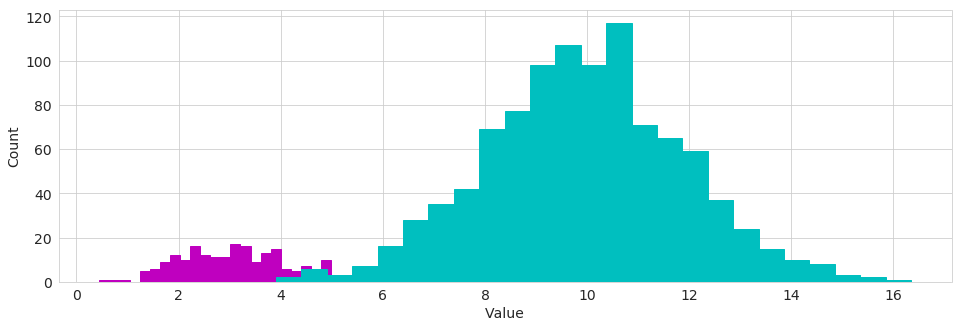

In [2]:
X = numpy.concatenate((numpy.random.normal(3, 1, 200), numpy.random.normal(10, 2, 1000)))
y = numpy.concatenate((numpy.zeros(200), numpy.ones(1000)))

x1 = X[:200]
x2 = X[200:]

plt.figure(figsize=(16, 5))
plt.hist(x1, bins=25, color='m', edgecolor='m', label="Class A")
plt.hist(x2, bins=25, color='c', edgecolor='c', label="Class B")
plt.xlabel("Value", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The data seems like it comes from two normal distributions, with the cyan class being more prevalent than the magenta class. A natural way to model this data would be to create a normal distribution for the cyan data, and another for the magenta distribution.

Let's take a look at doing that. All we need to do is use the `from_samples` class method of the `NormalDistribution` class.

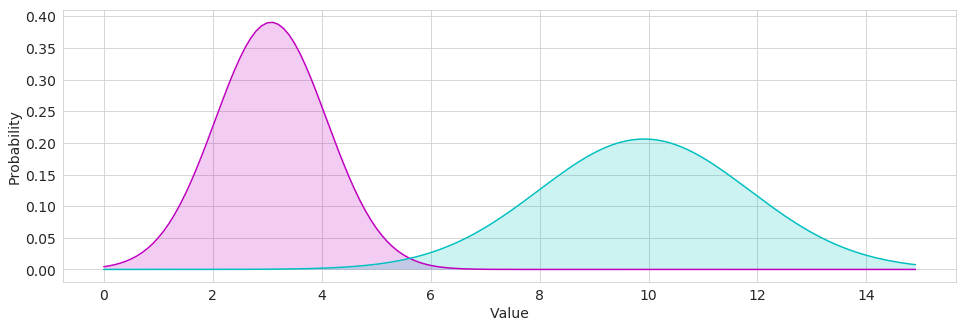

In [3]:
d1 = NormalDistribution.from_samples(x1)
d2 = NormalDistribution.from_samples(x2)
idxs = numpy.arange(0, 15, 0.1)

p1 = map(d1.probability, idxs)
p2 = map(d2.probability, idxs)

plt.figure(figsize=(16, 5))
plt.plot(idxs, p1, color='m'); plt.fill_between(idxs, 0, p1, facecolor='m', alpha=0.2)
plt.plot(idxs, p2, color='c'); plt.fill_between(idxs, 0, p2, facecolor='c', alpha=0.2)
plt.xlabel("Value", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

It looks like some aspects of the data are captured well by doing things this way-- specifically the mean and variance of the normal distributions. This allows us to easily calculate $P(D|M)$ as the probability of a sample under either the cyan or magenta distributions using the normal (or Gaussian) probability density equation:

\begin{align}
P(D|M) &= P(x|\mu, \sigma) \\
       &= \frac{1}{\sqrt{2\pi\sigma^{2}}} exp \left(-\frac{(x-u)^{2}}{2\sigma^{2}} \right) 
\end{align}

However, if we look at the original data, we see that the cyan distributions is both much wider than the purple distribution and much taller, as there were more samples from that class in general. If we reduce that data down to these two distributions, we lose the class imbalance. We want our prior to model this class imbalance, with the reasoning being that if we randomly draw a sample from the samples observed thus far, it is far more likely to be a cyan than a magenta sample. Let's take a look at this class imbalance exactly.

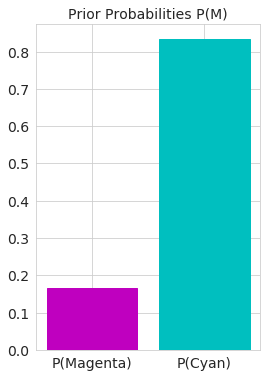

In [4]:
magenta_prior = 1. * len(x1) / len(X)
cyan_prior = 1. * len(x2) / len(X)

plt.figure(figsize=(4, 6))
plt.title("Prior Probabilities P(M)", fontsize=14)
plt.bar(0, magenta_prior, facecolor='m', edgecolor='m')
plt.bar(1, cyan_prior, facecolor='c', edgecolor='c')
plt.xticks([0, 1], ['P(Magenta)', 'P(Cyan)'], fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The prior $P(M)$ is a vector of probabilities over the classes that the model can predict, also known as components. In this case, if we draw a sample randomly from the data that we have, there is a ~83% chance that it will come from the cyan class and a ~17% chance that it will come from the magenta class.

Let's multiply the probability densities we got before by this imbalance.

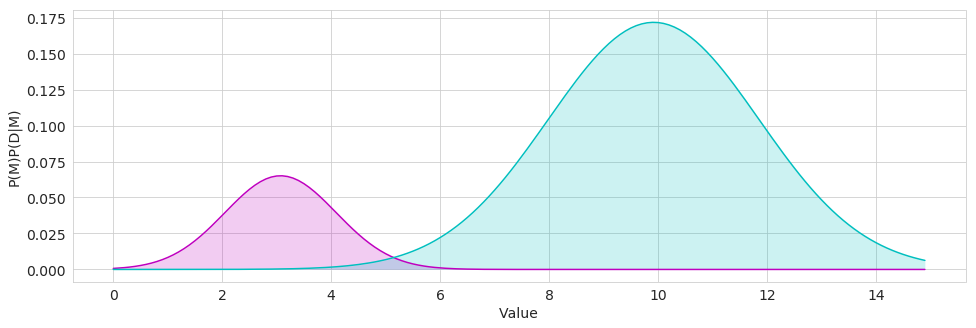

In [5]:
d1 = NormalDistribution.from_samples(x1)
d2 = NormalDistribution.from_samples(x2)
idxs = numpy.arange(0, 15, 0.1)

p_magenta = numpy.array(map(d1.probability, idxs)) * magenta_prior
p_cyan = numpy.array(map(d2.probability, idxs)) * cyan_prior

plt.figure(figsize=(16, 5))
plt.plot(idxs, p_magenta, color='m'); plt.fill_between(idxs, 0, p_magenta, facecolor='m', alpha=0.2)
plt.plot(idxs, p_cyan, color='c'); plt.fill_between(idxs, 0, p_cyan, facecolor='c', alpha=0.2)
plt.xlabel("Value", fontsize=14)
plt.ylabel("P(M)P(D|M)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

This looks a lot more faithful to the original data, and actually corresponds to $P(M)P(D|M)$, the prior multiplied by the likelihood. However, these aren't actually probability distributions anymore, as they no longer integrate to 1. This is why the $P(M)P(D|M)$ term has to be normalized by the $P(D)$ term in Bayes' rule in order to get a probability distribution over the components. However, $P(D)$ is difficult to determine exactly-- what is the probability of the data? Well, we can sum over the classes to get that value, since $P(D) = \sum_{i=1}^{c} P(D|M)P(M)$ for a problem with c classes. This translates into $P(D) = P(M=Cyan)P(D|M=Cyan) + P(M=Magenta)P(D|M=Magenta)$ for this specific problem, and those values can just be pulled from the unnormalized plots above.

This gives us the full Bayes' rule, with the posterior $P(M|D)$ being the proportion of density of the above plot coming from each of the two distributions at any point on the line. Let's take a look at the posterior probabilities of the two classes on the same line.

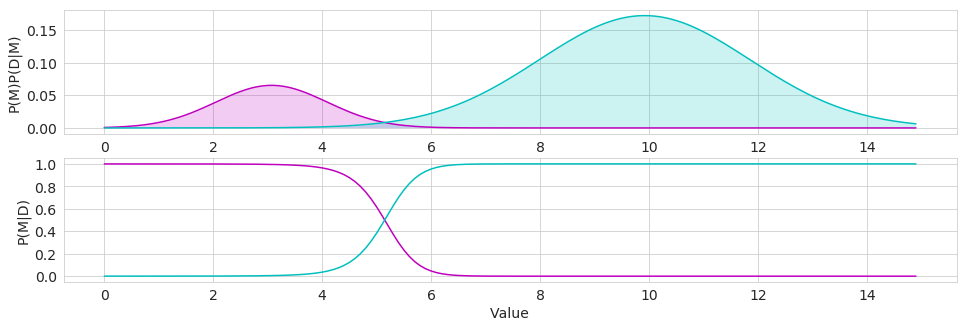

In [6]:
magenta_posterior = p_magenta / (p_magenta + p_cyan)
cyan_posterior = p_cyan / (p_magenta + p_cyan)

plt.figure(figsize=(16, 5))
plt.subplot(211)
plt.plot(idxs, p_magenta, color='m'); plt.fill_between(idxs, 0, p_magenta, facecolor='m', alpha=0.2)
plt.plot(idxs, p_cyan, color='c'); plt.fill_between(idxs, 0, p_cyan, facecolor='c', alpha=0.2)
plt.xlabel("Value", fontsize=14)
plt.ylabel("P(M)P(D|M)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(idxs, magenta_posterior, color='m')
plt.plot(idxs, cyan_posterior, color='c')
plt.xlabel("Value", fontsize=14)
plt.ylabel("P(M|D)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The top plot shows the same densities as before, while the bottom plot shows the proportion of the density belonging to either class at that point. This proportion is known as the posterior $P(M|D)$, and can be interpreted as the probability of that point belonging to each class. This is one of the native benefits of probabilistic models, that instead of providing a hard class label for each sample, they can provide a soft label in the form of the probability of belonging to each class.

We can implement all of this simply in pomegranate using the `NaiveBayes` class.

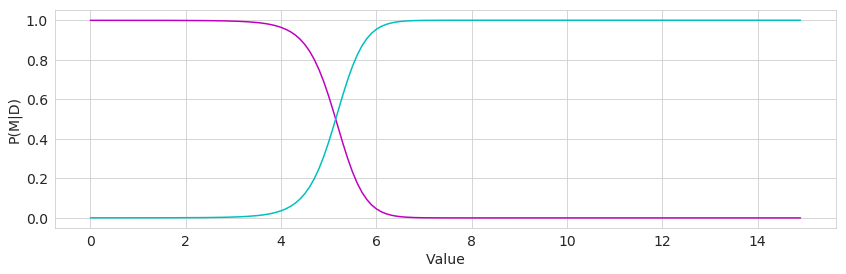

In [7]:
idxs = idxs.reshape(idxs.shape[0], 1)
X = X.reshape(X.shape[0], 1)

model = NaiveBayes.from_samples(NormalDistribution, X, y)
posteriors = model.predict_proba(idxs)

plt.figure(figsize=(14, 4))
plt.plot(idxs, posteriors[:,0], color='m')
plt.plot(idxs, posteriors[:,1], color='c')
plt.xlabel("Value", fontsize=14)
plt.ylabel("P(M|D)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Looks like we're getting the same plots for the posteriors just through fitting the naive Bayes model directly to data. The predictions made will come directly from the posteriors in this plot, with cyan predictions happening whenever the cyan posterior is greater than the magenta posterior, and vice-versa.

## Naive Bayes

In the univariate setting, naive Bayes is identical to a general Bayes classifier. The divergence occurs in the multivariate setting, the naive Bayes model assumes independence of all features, while a Bayes classifier is more general and can support more complicated interactions or covariances between features. Let's take a look at what this means in terms of Bayes' rule. 

\begin{align}
P(M|D) &= \frac{P(M)P(D|M)}{P(D)} \\
       &= \frac{P(M)\prod_{i=1}^{d}P(D_{i}|M_{i})}{P(D)}
\end{align}

This looks fairly simple to compute, as we just need to pass each dimension into the appropriate distribution and then multiply the returned probabilities together. This simplicity is one of the reasons why naive Bayes is so widely used. Let's look closer at using this in pomegranate, starting off by generating two blobs of data that overlap a bit and inspecting them.

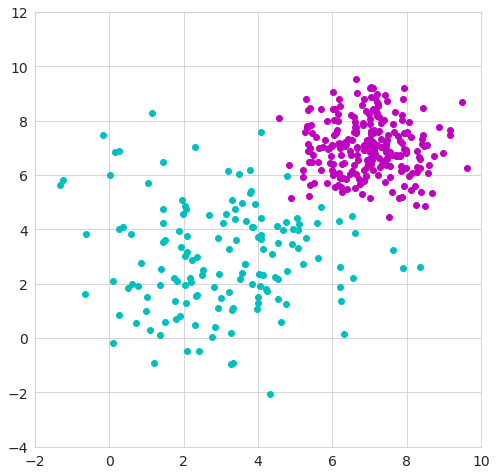

In [8]:
X = numpy.concatenate([numpy.random.normal(3, 2, size=(150, 2)), numpy.random.normal(7, 1, size=(250, 2))])
y = numpy.concatenate([numpy.zeros(150), numpy.ones(250)])

plt.figure(figsize=(8, 8))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m')
plt.xlim(-2, 10)
plt.ylim(-4, 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Now, let's fit our naive Bayes model to this data using pomegranate. We can use the `from_samples` class method, pass in the distribution that we want to model each dimension, and then the data. We choose to use `NormalDistribution` in this particular case, but any supported distribution would work equally well, such as `BernoulliDistribution` or `ExponentialDistribution`. To ensure we get the correct decision boundary, let's also plot the boundary recovered by sklearn.

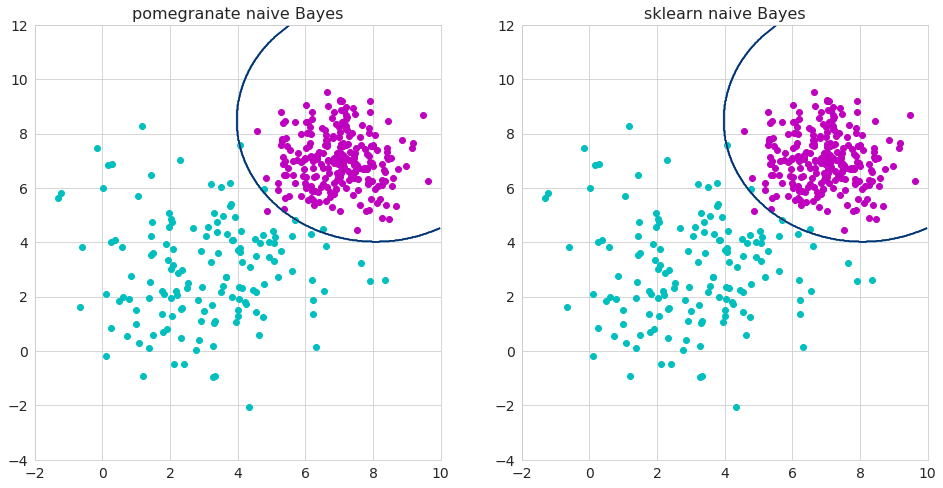

In [9]:
from sklearn.naive_bayes import GaussianNB

model = NaiveBayes.from_samples(NormalDistribution, X, y)
clf = GaussianNB().fit(X, y)

xx, yy = numpy.meshgrid(numpy.arange(-2, 10, 0.02), numpy.arange(-4, 12, 0.02))
Z1 = model.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = clf.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("pomegranate naive Bayes", fontsize=16)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m')
plt.contour(xx, yy, Z1, cmap='Blues')
plt.xlim(-2, 10)
plt.ylim(-4, 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.title("sklearn naive Bayes", fontsize=16)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m')
plt.contour(xx, yy, Z2, cmap='Blues')
plt.xlim(-2, 10)
plt.ylim(-4, 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Drawing the decision boundary helps to verify that we've produced a good result by cleanly splitting the two blobs from each other.

Bayes' rule provides a great deal of flexibility in terms of what the actually likelihood functions are. For example, when considering a multivariate distribution, there is no need for each dimension to be modeled by the same distribution. In fact, each dimension can be modeled by a different distribution, as long as we can multiply the $P(D|M)$ terms together. 

### Classifying Signal with Different Distributions on Different Features

Let's consider the example of some noisy signals that have been segmented. We know that they come from two underlying phenomena, the cyan phenomena and the magenta phenomena, and want to classify future segments. To do this, we have three features-- the mean signal of the segment, the standard deviation, and the duration.  

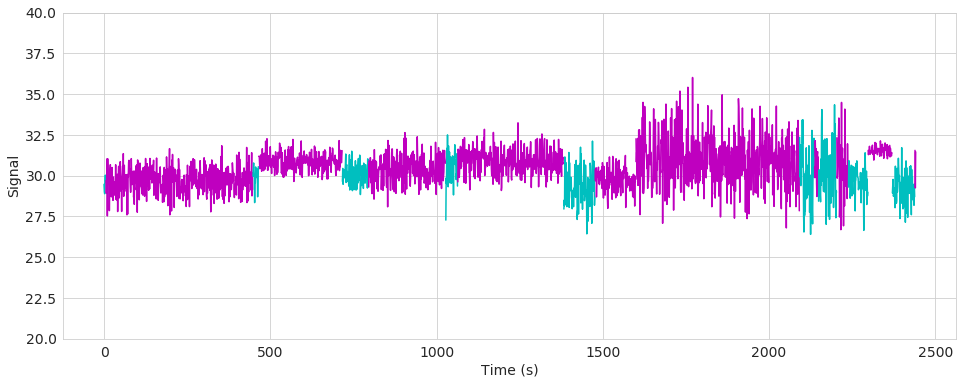

In [10]:
def plot_signal(X, n):
    plt.figure(figsize=(16, 6))
    t_current = 0
    for i in range(n):
        mu, std, t = X[i]
        chunk = numpy.random.normal(mu, std, int(t))
        plt.plot(numpy.arange(t_current, t_current+t), chunk, c='cm'[i % 2])
        t_current += t
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Signal", fontsize=14)
    plt.ylim(20, 40)
    plt.show()

def create_signal(n):
    X, y = [], []
    for i in range(n):
        mu = numpy.random.normal(30.0, 0.4)
        std = numpy.random.lognormal(-0.1, 0.4)
        t = int(numpy.random.exponential(50)) + 1
        X.append([mu, std, int(t)])
        y.append(0)

        mu = numpy.random.normal(30.5, 0.8)
        std = numpy.random.lognormal(-0.3, 0.6)
        t = int(numpy.random.exponential(200)) + 1
        X.append([mu, std, int(t)])
        y.append(1)
    
    return numpy.array(X), numpy.array(y)

X_train, y_train = create_signal(1000)
X_test, y_test = create_signal(250)
plot_signal(X_train, 20)

We can start by modeling each variable as Gaussians, like before, and see what accuracy we get.

In [11]:
model = NaiveBayes.from_samples(NormalDistribution, X_train, y_train)
print "Gaussian Naive Bayes: ", (model.predict(X_test) == y_test).mean()

clf = GaussianNB().fit(X_train, y_train)
print "sklearn Gaussian Naive Bayes: ", (clf.predict(X_test) == y_test).mean()

Gaussian Naive Bayes:  0.794
sklearn Gaussian Naive Bayes:  0.794


We get identical values for sklearn and for pomegranate, which is good. However, let's take a look at the data itself to see whether a Gaussian distribution is the appropriate distribution for the data.

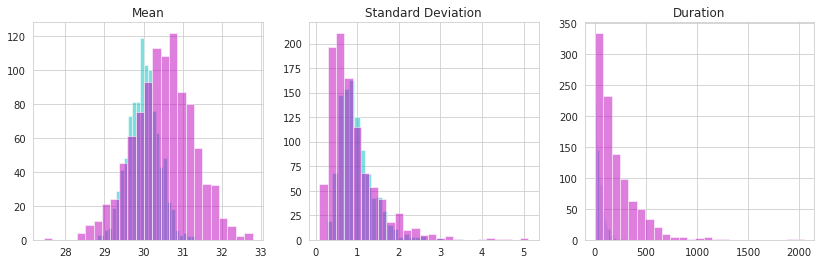

In [12]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.title("Mean")
plt.hist(X_train[y_train == 0, 0], color='c', alpha=0.5, bins=25)
plt.hist(X_train[y_train == 1, 0], color='m', alpha=0.5, bins=25)

plt.subplot(132)
plt.title("Standard Deviation")
plt.hist(X_train[y_train == 0, 1], color='c', alpha=0.5, bins=25)
plt.hist(X_train[y_train == 1, 1], color='m', alpha=0.5, bins=25)

plt.subplot(133)
plt.title("Duration")
plt.hist(X_train[y_train == 0, 2], color='c', alpha=0.5, bins=25)
plt.hist(X_train[y_train == 1, 2], color='m', alpha=0.5, bins=25)
plt.show()

So, unsurprisingly (since you can see that I used non-Gaussian distributions to generate the data originally), it looks like only the mean follows a normal distribution, whereas the standard deviation seems to follow either a gamma or a log-normal distribution. We can take advantage of that by explicitly using these distributions instead of approximating them as normal distributions. pomegranate is flexible enough to allow for this, whereas sklearn currently is not.

In [13]:
model = NaiveBayes.from_samples(NormalDistribution, X_train, y_train)
print "Gaussian Naive Bayes: ", (model.predict(X_test) == y_test).mean()

clf = GaussianNB().fit(X_train, y_train)
print "sklearn Gaussian Naive Bayes: ", (clf.predict(X_test) == y_test).mean()

model = NaiveBayes.from_samples([NormalDistribution, LogNormalDistribution, ExponentialDistribution], X_train, y_train)
print "Heterogeneous Naive Bayes: ", (model.predict(X_test) == y_test).mean()

Gaussian Naive Bayes:  0.794
sklearn Gaussian Naive Bayes:  0.794
Heterogeneous Naive Bayes:  0.822


It looks like we're able to get a small improvement in accuracy just by using appropriate distributions for the features, without any type of data transformation or filtering. This certainly seems worthwhile if you can determine what the appropriate underlying distribution is.

Next, there's obviously the issue of speed. Let's compare the speed of the pomegranate implementation and the sklearn implementation.

In [14]:
%timeit GaussianNB().fit(X_train, y_train)
%timeit NaiveBayes.from_samples(NormalDistribution, X_train, y_train)
%timeit NaiveBayes.from_samples([NormalDistribution, LogNormalDistribution, ExponentialDistribution], X_train, y_train)

1000 loops, best of 3: 475 µs per loop
1000 loops, best of 3: 318 µs per loop
1000 loops, best of 3: 363 µs per loop


Looks as if on this small dataset they're all taking approximately the same time. This is pretty much expected, as the fitting step is fairly simple and both implementations use C-level numerics for the calculations. We can give a more thorough treatment of the speed comparison on larger datasets. Let's look at the average time it takes to fit a model to data of increasing dimensionality across 25 runs.

In [15]:
pom_time, skl_time = [], []

n1, n2 = 15000, 60000,
for d in range(1, 101, 5): 
    X = numpy.concatenate([numpy.random.normal(3, 2, size=(n1, d)), numpy.random.normal(7, 1, size=(n2, d))])
    y = numpy.concatenate([numpy.zeros(n1), numpy.ones(n2)])

    tic = time.time()
    for i in range(25):
        GaussianNB().fit(X, y)
    skl_time.append((time.time() - tic) / 25)
    
    tic = time.time()
    for i in range(25):
        NaiveBayes.from_samples(NormalDistribution, X, y)
    pom_time.append((time.time() - tic) / 25)

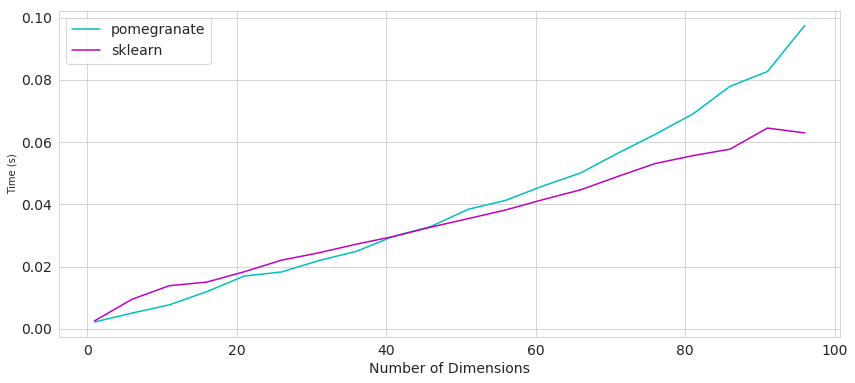

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(range(1, 101, 5), pom_time, color='c', label="pomegranate")
plt.plot(range(1, 101, 5), skl_time, color='m', label="sklearn")
plt.xticks(fontsize=14)
plt.xlabel("Number of Dimensions", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Time (s)")
plt.legend(fontsize=14)
plt.show()

It appears as if the two implementations are basically the same speed. This is unsurprising given the simplicity of the calculations, and as mentioned before, the low level implementation.

### Multivariate Gaussian Bayes Classifiers

The natural generalization of the naive Bayes classifier is to allow any multivariate function take the place of $P(D|M)$ instead of it being the product of several univariate probability distributions. One immediate difference is that now instead of creating a Gaussian model with effectively a diagonal covariance matrix, you can now create one with a full covariance matrix. Let's see an example of that at work.

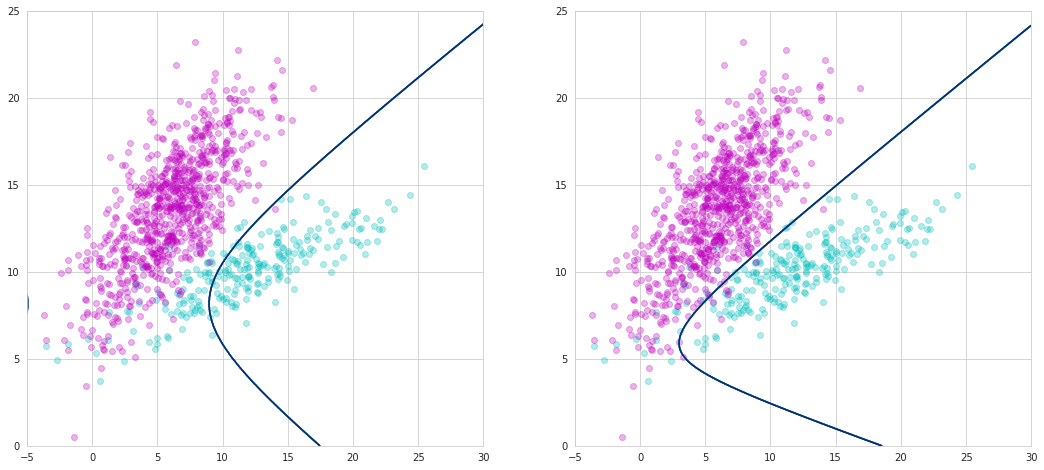

In [17]:
tilt_a = [[-2, 0.5], [5, 2]]
tilt_b = [[-1, 1.5], [3, 3]]

X = numpy.concatenate((numpy.random.normal(4, 1, size=(250, 2)).dot(tilt_a), numpy.random.normal(3, 1, size=(800, 2)).dot(tilt_b)))
y = numpy.concatenate((numpy.zeros(250), numpy.ones(800)))

model_a = NaiveBayes.from_samples(NormalDistribution, X, y)
model_b = BayesClassifier.from_samples(MultivariateGaussianDistribution, X, y)

xx, yy = numpy.meshgrid(numpy.arange(-5, 30, 0.02), numpy.arange(0, 25, 0.02))
Z1 = model_a.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = model_b.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.contour(xx, yy, Z1, cmap='Blues')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c', alpha=0.3)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m', alpha=0.3)
plt.xlim(-5, 30)
plt.ylim(0, 25)

plt.subplot(122)
plt.contour(xx, yy, Z2, cmap='Blues')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c', alpha=0.3)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m', alpha=0.3)
plt.xlim(-5, 30)
plt.ylim(0, 25)
plt.show()

It looks like we are able to get a better boundary between the two blobs of data. The primary for this is because the data don't form spherical clusters, like you assume when you force a diagonal covariance matrix, but are tilted ellipsoids, that can be better modeled by a full covariance matrix. We can quantify this quickly by looking at performance on the training data.

In [18]:
print "naive training accuracy: {:4.4}".format((model_a.predict(X) == y).mean())
print "bayes classifier training accuracy: {:4.4}".format((model_b.predict(X) == y).mean())

naive training accuracy: 0.9219
bayes classifier training accuracy: 0.9695


Looks like there is a significant boost. Naturally you'd want to evaluate the performance of the model on separate validation data, but for the purposes of demonstrating the effect of a full covariance matrix this should be sufficient.

### Gaussian Mixture Model Bayes Classifier

While using a full covariance matrix is certainly more complicated than using only the diagonal, there is no reason that the $P(D|M)$ has to even be a single simple distribution versus a full probabilistic model. After all, all probabilistic models, including general mixtures, hidden Markov models, and Bayesian networks, can calculate $P(D|M)$. Let's take a look at an example of using a mixture model instead of a single gaussian distribution.

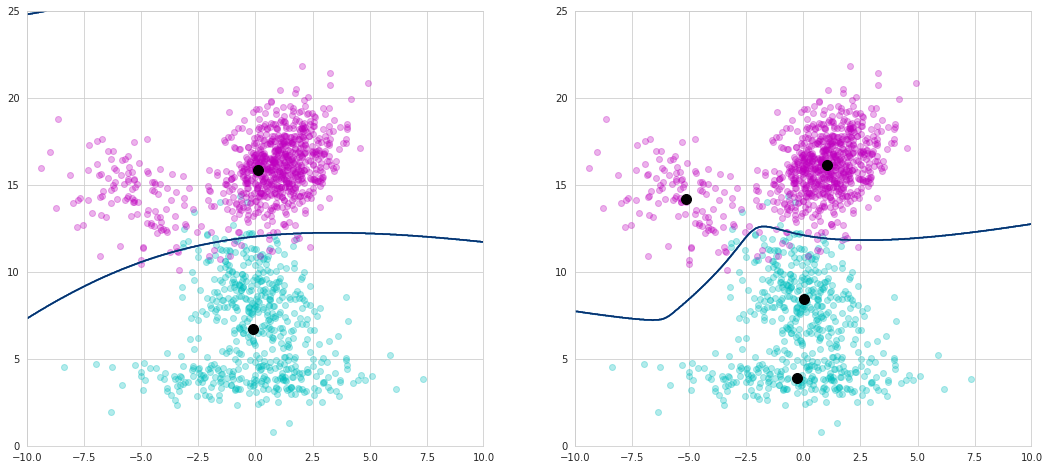

In [19]:
X = numpy.empty(shape=(0, 2))
X = numpy.concatenate((X, numpy.random.normal(4, 1, size=(200, 2)).dot([[-2, 0.5], [2, 0.5]])))
X = numpy.concatenate((X, numpy.random.normal(3, 1, size=(350, 2)).dot([[-1, 2], [1, 0.8]])))
X = numpy.concatenate((X, numpy.random.normal(7, 1, size=(700, 2)).dot([[-0.75, 0.8], [0.9, 1.5]])))
X = numpy.concatenate((X, numpy.random.normal(6, 1, size=(120, 2)).dot([[-1.5, 1.2], [0.6, 1.2]])))
y = numpy.concatenate((numpy.zeros(550), numpy.ones(820)))

model_a = BayesClassifier.from_samples(MultivariateGaussianDistribution, X, y)

gmm_a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X[y == 0])
gmm_b = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X[y == 1])
model_b = BayesClassifier([gmm_a, gmm_b], weights=numpy.array([1-y.mean(), y.mean()]))

xx, yy = numpy.meshgrid(numpy.arange(-10, 10, 0.02), numpy.arange(0, 25, 0.02))
Z1 = model_a.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = model_b.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
centroids1 = numpy.array([distribution.mu for distribution in model_a.distributions])
centroids2 = numpy.concatenate([[distribution.mu for distribution in component.distributions] for component in model_b.distributions])

plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.contour(xx, yy, Z1, cmap='Blues')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c', alpha=0.3)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m', alpha=0.3)
plt.scatter(centroids1[:,0], centroids1[:,1], color='k', s=100)

plt.subplot(122)
plt.contour(xx, yy, Z2, cmap='Blues')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c', alpha=0.3)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m', alpha=0.3)
plt.scatter(centroids2[:,0], centroids2[:,1], color='k', s=100)
plt.show()

Frequently in the real world you will end up with data that looks like the ones in the above plots, not neatly falling into any single simple distribution. Using a mixture here allowed us to model the various components separately and get a more sophisticated decision boundary that doesn't seem to be extremely overfit.

If one wanted to use hidden Markov models to model sequences, all that needs to change is passing in `HiddenMarkovModel` objects instead of `GeneralMixtureModel` ones. Likewise, Bayesian networks are similarly supported and can be passed in just as easily. In fact, the most stacking one could reasonably do is to create a Bayes classifier that distinguishes mixtures of hidden Markov models with mixture emissions (GMM-HMM-GMMs) from each other!